In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
# %matplotlib inline
import matplotlib.pyplot as plt
import cv2
from kitti_object import *


In [3]:
from xvfbwrapper import Xvfb
vdisplay = Xvfb(width=1920, height=1080)
vdisplay.start()
from mayavi import mlab
mlab.init_notebook('ipy') # do not use 'x3d' backend which leads to color missing

/root/miniconda3/envs/kitti_vis/lib/python3.8/site-packages/traits/etsconfig/etsconfig.py:412: UserWarning: Environment variable "HOME" not set, setting home directory to /tmp
  warn(


Notebook initialized with ipy backend.


In [69]:
# 
from glob import glob
import os
paths = glob('../waymo_kitti_converter/data/waymo/training/calib/*.txt')
ids = [int(os.path.basename(path).split('.')[0]) for path in paths]
len(ids)

19324

../waymo_kitti_converter/data/waymo/ training
../waymo_kitti_converter/data/waymo/training/velodyne/0069066.bin


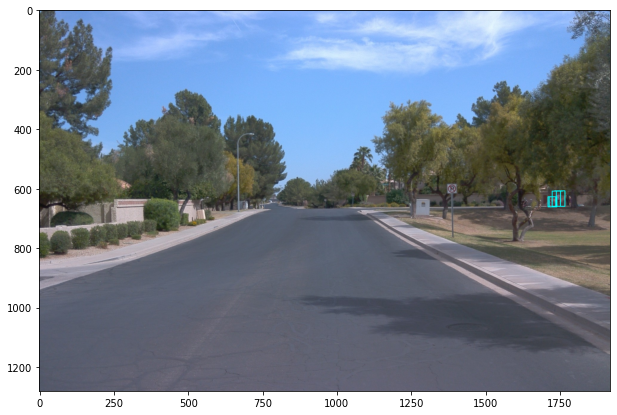

In [77]:
ids = list(sorted(ids))
data_idx = np.random.choice(ids)#list(sorted(ids[0]))
# data_idx

# dataset = kitti_object('../data/kitti/psedo/', 'training')
dataset = kitti_object('../waymo_kitti_converter/data/waymo/', 
                       'training', img_ext='jpg', cam_id=0)
dataset.num_samples = 100000

objects = dataset.get_label_objects(data_idx)
pc_velo = dataset.get_lidar(data_idx)
calib = dataset.get_calibration(data_idx)
img = dataset.get_image(data_idx)
img_height, img_width, _ = img.shape

# fig_3d = mlab.figure(bgcolor=(0, 0, 0), size=(800, 450))
# show_lidar_with_depth(pc_velo, objects, calib, fig_3d, True, img_width, img_height)

# calib.P = calib.calibs['P2']
# calib.P = np.reshape(calib.P, [3, 4])

img_bbox2d, img_bbox3d = show_image_with_boxes(img, objects, calib, show3d=0)

# img_bbox2d = cv2.cvtColor(img_bbox2d, cv2.COLOR_BGR2RGB)
# fig_bbox2d = plt.figure(figsize=(14, 7))
# ax_bbox2d = fig_bbox2d.subplots()
# ax_bbox2d.imshow(img_bbox2d)
# plt.show()

img_bbox3d = cv2.cvtColor(img_bbox3d, cv2.COLOR_BGR2RGB)
fig_bbox3d = plt.figure(figsize=(14, 7))
ax_bbox3d = fig_bbox3d.subplots()
ax_bbox3d.imshow(img_bbox3d)
plt.show()

In [57]:
def show_lidar_topview_with_boxes(pc_velo, objects, calib, objects_pred=None):
    """ top_view image"""
    # print('pc_velo shape: ',pc_velo.shape)
    top_view = utils.lidar_to_top(pc_velo)
#     top_view = top_view/top_view.mean()

    top_image = utils.draw_top_image(top_view)
    top_image = top_image*100/top_image.mean()
    print("top_image:", top_image.shape)
#     import ipdb;ipdb.set_trace()
    def bbox3d(obj):
        _, box3d_pts_3d = utils.compute_box_3d(obj, calib.P)
        box3d_pts_3d_velo = calib.project_rect_to_velo(box3d_pts_3d)
        return box3d_pts_3d_velo

    boxes3d = [bbox3d(obj) for obj in objects if obj.type != "DontCare"]
    gt = np.array(boxes3d)
    # print("box2d BV:",boxes3d)
    lines = [obj.type for obj in objects if obj.type != "DontCare"]
    top_image = utils.draw_box3d_on_top(
        top_image, gt, text_lables=lines, scores=None, thickness=1, is_gt=True
    )
    # pred
    if objects_pred is not None:
        boxes3d = [bbox3d(obj) for obj in objects_pred if obj.type != "DontCare"]
        gt = np.array(boxes3d)
        lines = [obj.type for obj in objects_pred if obj.type != "DontCare"]
        top_image = utils.draw_box3d_on_top(
            top_image, gt, text_lables=lines, scores=None, thickness=1, is_gt=False
        )

    cv2.imshow("top_image", top_image)
    return top_image

top_image: (500, 300, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


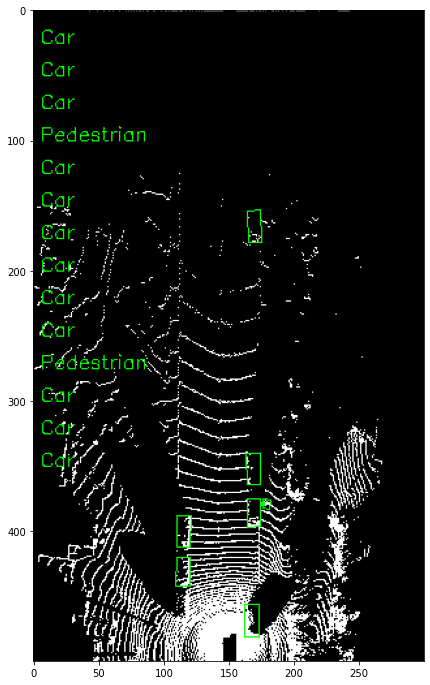

In [58]:
img_bev = show_lidar_topview_with_boxes(pc_velo, objects, calib)

fig_bev = plt.figure(figsize=(7, 14))
ax_bev = fig_bev.subplots()
ax_bev.imshow(img_bev)
plt.show()